1. Imports

In [2]:
import torch
import numpy as np
import torch.nn as nn
from torch.nn import functional as F
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib as mpl
from matplotlib import pyplot as plt
from MALARIA2 import MALARIA
import localizerVgg
from scipy.ndimage.filters import maximum_filter, median_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from PIL import Image
import utils
from os import mkdir, path

2. Hyper-parameters:

In [15]:
NUM_CLASSES = 2
model_name = 'c-2_l2_b-0.0_e-10.pt'

2. Functions

In [4]:
def get_subdirectory(sd):
    dir = path.join('figures', sd)
    if not path.isdir(dir):
        mkdir(dir)
    return dir


def save_images(img, map, gam, peak_map, batch_idx, path_save):
    # Normalzize img
    img = img.cpu().numpy().squeeze().transpose(1, 2, 0)
    img = np.uint8((img - img.min()) * 255 / (img.max() - img.min()))
    img = Image.fromarray(img)
    path_img = path.join(path_save, f'image-batch_{batch_idx}.bmp')
    img.save(path_img)
    # img.save("results/image-batch_" + str(batch_idx) + ".bmp")
    # Get first peakmap from the batch
    peak_map = np.uint8(np.array(peak_map[0]) * 255)
    for i in range(map.shape[0]):
        a = map[i]
        b = gam[i]
        ima = Image.fromarray(a)
        imb = Image.fromarray(b)
        peakI = Image.fromarray(peak_map[i]).convert("RGB")
        peakI = peakI.resize((1600, 1200))
        path_ima = path.join(path_save, f'heatmap-class_{i}_batch_{batch_idx}.bmp')
        path_imb = path.join(path_save, f'gt_heatmap-class_{i}_batch_{batch_idx}.bmp')
        path_peak = path.join(path_save, f'peakmap-class_{i}_batch_{batch_idx}.bmp')
        ima.save(path_ima)
        imb.save(path_imb)
        peakI.save(path_peak)
        # ima.save("results/heatmap-class_" + str(i) + '-batch_' + str(batch_idx) + ".bmp")
        # imb.save("results/gt_heatmap-class_" + str(i) + '-batch_' + str(batch_idx) + ".bmp")
        # peakI.save("results/peakmap-class_" + str(i) + '-batch_' + str(batch_idx) + ".bmp")


def find_inliers(x):
    """ Returns inliers from x. x shape is (num_samples, num_classes)"""
    percent = 95
    prctile = np.percentile(x, percent, axis=0)
    print(f'{percent}-th percentile {prctile}')
    inliers = x < prctile
    inliers = np.bitwise_and.reduce(inliers, axis=1)
    return inliers


def plot_graphs(gt, pred):
    if gt.shape[1] == 2:
        plt.figure(1)
        plt.subplot(1, 2, 1)
        plt.scatter(gt[:, 0], pred[:, 0])
        plt.ylabel('Model count')
        plt.xlabel('GT count')
        plt.title('Not infected cells')
        plt.subplot(1, 2, 2)
        plt.scatter(gt[:, 1], pred[:, 1])
        plt.ylabel('Model count')
        plt.xlabel('GT count')
        plt.title('Infected cells')
        plt.show()

    elif gt.shape[1] == 7:
        plt.figure(1, figsize=(30, 5))
        for i in range(gt.shape[1]):
            plt.subplot(1, 7, i+1)
            plt.scatter(gt[:, i], pred[:, i])
            plt.ylabel('Model count')
            plt.xlabel('GT count')
            plt.title(f'Class {i}')
        plt.show()

3. Main

MALARIA dataset set=train number of classes=002  number of images=1208


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


[0/108]	 AE: [0. 0.]
[1/108]	 AE: [0. 1.]
[2/108]	 AE: [1. 0.]
[3/108]	 AE: [2. 1.]
[4/108]	 AE: [1. 0.]
[5/108]	 AE: [1. 0.]
[6/108]	 AE: [1. 0.]
[7/108]	 AE: [14.  1.]
[8/108]	 AE: [0. 0.]
[9/108]	 AE: [11.  1.]
[10/108]	 AE: [2. 0.]
[11/108]	 AE: [1. 0.]
[12/108]	 AE: [2. 4.]
[13/108]	 AE: [1. 0.]
[14/108]	 AE: [2. 1.]
[15/108]	 AE: [2. 2.]
[16/108]	 AE: [1. 0.]
[17/108]	 AE: [0. 0.]
[18/108]	 AE: [3. 0.]
[19/108]	 AE: [4. 0.]
[20/108]	 AE: [5. 0.]
[21/108]	 AE: [3. 0.]
[22/108]	 AE: [0. 4.]
[23/108]	 AE: [4. 1.]
[24/108]	 AE: [1. 2.]
[25/108]	 AE: [3. 0.]
[26/108]	 AE: [0. 0.]
[27/108]	 AE: [1. 0.]
[28/108]	 AE: [8. 4.]
[29/108]	 AE: [1. 2.]
[30/108]	 AE: [0. 0.]
[31/108]	 AE: [0. 1.]
[32/108]	 AE: [2. 0.]
[33/108]	 AE: [5. 2.]
[34/108]	 AE: [2. 1.]
[35/108]	 AE: [6. 3.]
[36/108]	 AE: [10.  1.]
[37/108]	 AE: [1. 0.]
[38/108]	 AE: [2. 1.]
[39/108]	 AE: [0. 0.]
[40/108]	 AE: [0. 0.]
[41/108]	 AE: [1. 0.]
[42/108]	 AE: [5. 0.]
[43/108]	 AE: [1. 0.]
[44/108]	 AE: [0. 0.]
[45/108]	 AE: 

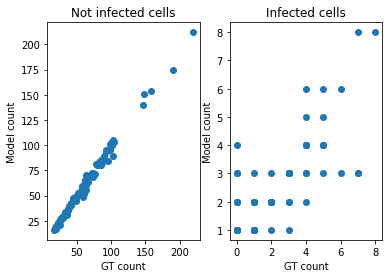

MAE:  [2.0462963  0.61111111]
nMAE:  [0.0330492  0.30697674]
RMSE:  [3.47610894 1.12216722]
NRMSE:  [0.05614173 0.5636933 ]
Done


In [16]:
# Create sub directory if it does not exist
sd_path = get_subdirectory(model_name)
saved_model_path = path.join('saved models', model_name)

cm_jet = mpl.cm.get_cmap('jet')
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Load pretrained model

dataset = MALARIA('', 'train', train=True, num_classes=NUM_CLASSES)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [1100, 108], generator=torch.Generator().manual_seed(42)) # [1100, 108]

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

model = localizerVgg.localizervgg16(num_classes=test_dataset.dataset.get_number_classes(), pretrained=True)
state_dict = torch.load(saved_model_path, map_location=torch.device(device))
model.load_state_dict(state_dict)
model = model.to(device)
model.eval()

predicted_count, gt_count = [], []
# Set threshold as vector
if NUM_CLASSES == 2:
    thr = [0.5, 0.8]
elif NUM_CLASSES == 7:
    thr = [0.5, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8]
thr = np.array(thr).reshape(NUM_CLASSES, 1, 1)
with torch.no_grad():
    for batch_idx, (data, GAM, num_cells) in enumerate(test_loader, 0):
        data, GAM, num_cells = data.to(device, dtype=torch.float),  GAM.to(device), num_cells.to(device)
        MAP = model(data)
        # Create cMap for multi class
        cMap = MAP.data.cpu().numpy()
        cMap_min = cMap.min(axis=(2,3)).reshape((cMap.shape[0], cMap.shape[1], 1, 1))
        cMap_max = cMap.max(axis=(2,3)).reshape((cMap.shape[0], cMap.shape[1], 1, 1))
        cMap = (cMap - cMap_min) / (cMap_max - cMap_min)
        cMap[cMap < thr] = 0
        # Detect peaks in the predicted heat map:
        peakMAPs = utils.detect_peaks_multi_channels_batch(cMap)

        # MAP & GAM shape is [B, C, H, W]. Reshape to [B, C, H*W]
        # MAP = MAP.view(MAP.shape[0], MAP.shape[1], -1)
        # GAM = GAM.view(GAM.shape[0], GAM.shape[1], -1)

        pred_num_cells = np.sum(peakMAPs, axis=(2, 3))
        pred_num_cells_batch = np.sum(pred_num_cells, axis=0)
        num_cells_batch = num_cells.cpu().detach().numpy().sum(axis=0)

        # Append counts to lists
        predicted_count.append(pred_num_cells_batch)
        gt_count.append(num_cells_batch)

        # Average absolute error of cells counting (average over batch)
        l = abs(pred_num_cells_batch - num_cells_batch) / num_cells.shape[0]

        print(f'[{batch_idx}/{len(test_loader)}]\t AE: {l}')

        # Save images
        if batch_idx % 100 == 0:
            MAP_norm = utils.normalize_map(MAP)
            GAM_norm = GAM[0].data.cpu().contiguous().numpy().copy()
            MAP_upsampled = utils.upsample_map(MAP_norm, dsr=8)
            GAM_upsampled = utils.upsample_map(GAM_norm, dsr=8)
            save_images(data, MAP_upsampled, GAM_upsampled, peakMAPs, batch_idx, sd_path)

    predicted_count = np.array(predicted_count, dtype=int)
    gt_count = np.array(gt_count, dtype=int)

    total_num_samples = gt_count.shape[0]
    # Remove outliers
    # inliers = find_inliers(np.abs(predicted_count - gt_count))
    # gt_count = gt_count[inliers, :]
    # predicted_count = predicted_count[inliers, :]
    # inliers_num = gt_count.shape[0]
    # print(f'{total_num_samples - inliers_num} outliers omitted.')

    # Plot results
    plot_graphs(gt_count, predicted_count)

    mean_gt = np.mean(gt_count, axis=0)
    MAE = np.mean(np.abs(predicted_count - gt_count), axis=0)
    nMAE = MAE / mean_gt
    RMSE = np.sqrt(np.mean((predicted_count - gt_count)**2, axis=0))
    NRMSE = RMSE / mean_gt

    print('MAE: ', MAE)
    print('nMAE: ', nMAE)
    print('RMSE: ', RMSE)
    print('NRMSE: ', NRMSE)

    print('Done')